# Project: Active Data Augmentation & Model Patching

## 1. Introduction
In Deep Learning, data is the fuel. However, collecting labeled data is expensive and time-consuming. **Data Augmentation** is the technique of artificially expanding a dataset by creating modified versions of images (rotations, color jitters, shears) to improve model generalization.

### Why is this important?
1.  **Combats Overfitting:** Prevents the model from memorizing specific pixel patterns.
2.  **Encodes Invariance:** Teaches the model that a "rotated cat" is still a cat.
3.  **Robustness:** Helps the model handle noisy or imperfect real-world data.

In this project, we explore **Active Data Augmentation**. Instead of blindly applying random transformations, can we force the model to learn from the *best* possible variations?

## 2. Algorithms Overview

We compare three distinct strategies to train a ResNet-18 on CIFAR-10. We'll search for the best accuracy in classifying the images of the dataset

### 🟢 Strategy A: Standard Baseline (RandAugment)
This is the industry standard. For every image in a batch, we apply a random set of geometric and color transformations. The model sees a different variation at every epoch.

* **Logic:** $x_{aug} = T(x)$, where $T$ is a transformation function sampled randomly.
* **Goal:** General statistical coverage of the augmentation space.

![Figure 1: Standard Pipeline](img/randaugment.png)
*(Figure 1: Standard Pipeline where transformations are applied blindly)*

| **Pros** | **Cons** |
| :--- | :--- |
| ✅ **Fast:** No overhead during training. | ❌ **Inefficient:** Many augmentations are too easy and don't teach the model anything new. |
| ✅ **Simple:** Built-in to all frameworks (PyTorch/TF). | ❌ **Uncontrolled:** No guarantee that the augmented image is useful for the decision boundary. |

---

### 🔵 Strategy B: Uncertainty-Based Sampling (Max Loss)
This is the core "Smart" algorithm implemented in this project. Instead of feeding a random variation, we generate $K$ candidates and ask the model: *"Which one is the most confusing for you?"*.

* **Logic:**
    1. Generate $K$ augmented versions: $\{x_1, x_2, ..., x_K\}$.
    2. Compute Loss for all $K$ (Forward pass only).
    3. Train on $x_{hardest} = \arg\max_{x_i} Loss(x_i)$.

![Figure 2: Max Loss Logic](img/Max%20loss.png)
*(Figure 2: The Max Loss selection process selecting the sample with the highest error)*

| **Pros** | **Cons** |
| :--- | :--- |
| ✅ **Data Efficiency:** The model only trains on "informative" samples (Hard Examples). | ❌ **Slow:** Requires $K$ forward passes for every image (Computationally expensive). |
| ✅ **Robustness:** Forces the model to fix its weaknesses immediately. | ❌ **Risk of Divergence:** Can be too hard at the beginning of training (noisy gradients). |

### 🟢🔵 Strategy C: Dynamic Curriculum Learning (Extension)
To solve the stability issues of *Max Loss* and the inefficiency of *Random Augmentation*, we propose a hybrid **Curriculum** approach. Just like a human student, the model starts with easy tasks and progressively faces harder challenges.

* **Phase 1 (Warmup):** Train on Original images (Stability).
* **Phase 2 (Exploration):** Train on Random Augmentations (Diversity).
* **Phase 3 (Hardening):** Train on Max Loss Augmentations (Robustness).

| **Pros** | **Cons** |
| :--- | :--- |
| ✅ **Optimal Convergence:** Combines stability early on and robustness later. | ❌ **Hyperparameters:** Requires tuning the phase switching epochs. |
| ✅ **Best of Both Worlds:** Faster than pure Max Loss, better accuracy than Baseline. | |

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import json
import os
import gc

# --- CONFIGURATION ---
RESULTS_DIR = "./results"  # Folder where your .json files are stored
DATA_DIR = "./data"        # Folder where the dataset will be downloaded
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"✅ Setup Complete.")
print(f"   Device: {DEVICE}")
print(f"   Results Directory: {os.path.abspath(RESULTS_DIR)}")

# --- 1. VERIFY RESULTS ---
if os.path.exists(RESULTS_DIR):
    files = [f for f in os.listdir(RESULTS_DIR) if f.endswith('.json')]
    print(f"   Found {len(files)} experiment logs: {files}")
else:
    print("⚠️ WARNING: Results directory not found. Comparison plots might fail.")

# --- 2. DOWNLOAD DATASET (Automatic) ---
print("\n⬇️ Checking Dataset...")

# Transformation simple pour le chargement
base_transform = transforms.Compose([transforms.ToTensor()])

# Le paramètre 'download=True' vérifie si les fichiers sont là.
# S'ils manquent, il les télécharge. S'ils sont là, il ne fait rien.
trainset = torchvision.datasets.CIFAR10(root=DATA_DIR, train=True, 
                                        download=True, transform=base_transform)
testset = torchvision.datasets.CIFAR10(root=DATA_DIR, train=False, 
                                       download=True, transform=base_transform)

# Définition des classes pour l'affichage plus tard
classes = ('Plane', 'Car', 'Bird', 'Cat', 'Deer', 
           'Dog', 'Frog', 'Horse', 'Ship', 'Truck')

print(f"✅ Dataset Loaded: {len(trainset)} training images, {len(testset)} test images.")

✅ Setup Complete.
   Device: cuda
   Results Directory: /home/picqf/SDD/projet_deep/results
   Found 5 experiment logs: ['curriculum_run.json', 'patched_model.json', 'maxloss_run.json', 'flawed_model.json', 'baseline_run.json']

⬇️ Checking Dataset...


100%|██████████| 170M/170M [00:11<00:00, 15.1MB/s] 


✅ Dataset Loaded: 50000 training images, 10000 test images.


## 3. Experimental Approach & Results

### 3.1 Data & Augmentation Visualization

Before analyzing the performance, it is crucial to visualize what the model actually sees.

1.  **Raw Data:** CIFAR-10 images are low-resolution ($32 \times 32$ pixels).
2.  **Augmentations:** We verify that our transformations (Rotation, Shear, Cutout) are **"semantically safe"**.
    * *Goal:* The image should change enough to be "new" to the model.
    * *Constraint:* It must not change so much that a human can no longer recognize the object.

Below, we display a random batch of raw images, followed by the specific augmentations used in our **Max Loss** strategy.

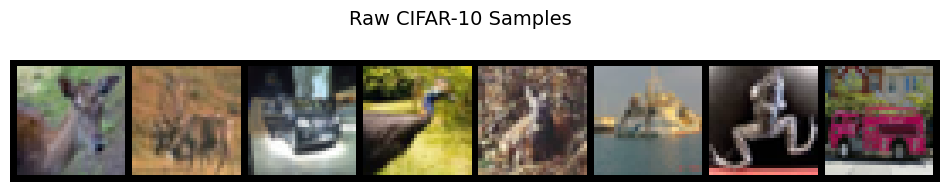

Labels: Deer  Deer  Car   Bird  Deer  Ship  Frog  Truck


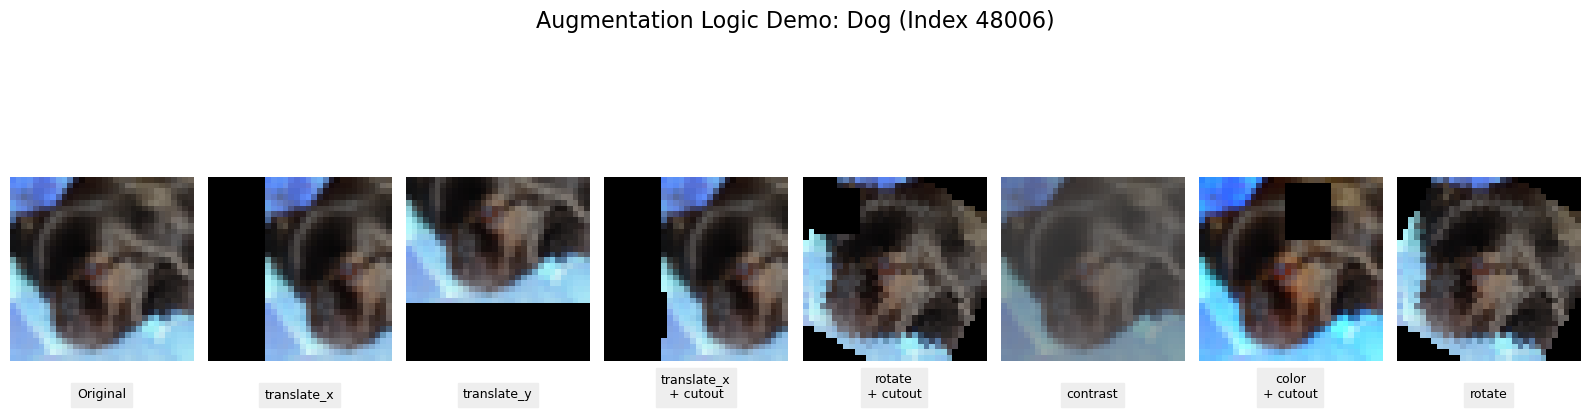

In [19]:
import random
import torchvision.transforms.functional as TF

# --- 1. DEFINE AUGMENTATION LOGIC (For Visualization) ---
class AugmentationSpace:
    def __init__(self):
        self.ops = ['rotate', 'translate_x', 'translate_y', 'shear_x', 'shear_y',
                    'contrast', 'brightness', 'sharpness', 'color']

    def apply(self, img, op_name, magnitude):
        m = magnitude / 10.0
        if op_name == 'rotate':
            degrees = m * 30.0 
            if random.random() > 0.5: degrees *= -1
            return TF.rotate(img, degrees)
        elif op_name == 'translate_x':
            pixels = m * (img.shape[2] * 0.3)
            if random.random() > 0.5: pixels *= -1
            return TF.affine(img, angle=0, translate=(pixels, 0), scale=1.0, shear=0)
        elif op_name == 'translate_y':
            pixels = m * (img.shape[1] * 0.3)
            if random.random() > 0.5: pixels *= -1
            return TF.affine(img, angle=0, translate=(0, pixels), scale=1.0, shear=0)
        elif op_name == 'shear_x':
            degrees = m * 30.0 
            if random.random() > 0.5: degrees *= -1
            return TF.affine(img, angle=0, translate=(0, 0), scale=1.0, shear=(degrees, 0))
        elif op_name == 'shear_y':
            degrees = m * 30.0
            if random.random() > 0.5: degrees *= -1
            return TF.affine(img, angle=0, translate=(0, 0), scale=1.0, shear=(0, degrees))
        elif op_name == 'contrast':
            factor = 1.0 + (m * 0.9) if random.random() > 0.5 else 1.0 - (m * 0.5)
            return TF.adjust_contrast(img, factor)
        elif op_name == 'brightness':
            factor = 1.0 + (m * 0.9) if random.random() > 0.5 else 1.0 - (m * 0.5)
            return TF.adjust_brightness(img, factor)
        elif op_name == 'sharpness':
            factor = 1.0 + m if random.random() > 0.5 else 1.0 - (m * 0.8) 
            return TF.adjust_sharpness(img, factor)
        elif op_name == 'color':
            factor = 1.0 + (m * 0.9) if random.random() > 0.5 else 1.0 - (m * 0.5)
            return TF.adjust_saturation(img, factor)
        return img

aug_space = AugmentationSpace()

def generate_augmentations(image_tensor, K=4, magnitude=6, return_names=True):
    augmented_images = []
    op_names = []
    
    # Original
    augmented_images.append(image_tensor)
    if return_names: op_names.append("Original")
    
    for _ in range(K - 1):
        op_name = random.choice(aug_space.ops)
        aug_img = aug_space.apply(image_tensor, op_name, magnitude)
        display_name = op_name
        
        if random.random() > 0.5:
            eraser = transforms.RandomErasing(p=1, scale=(0.02, 0.15), ratio=(0.3, 3.3))
            aug_img = eraser(aug_img)
            display_name += "\n+ cutout"
            
        augmented_images.append(aug_img)
        if return_names: op_names.append(display_name)
    
    return torch.stack(augmented_images), op_names

# --- 2. LOAD DATA (If not already loaded) ---
base_transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=base_transform)
classes = ('Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck')

# --- 3. DISPLAY RAW SAMPLES ---
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

dataiter = iter(torch.utils.data.DataLoader(trainset, batch_size=8, shuffle=True))
images, labels = next(dataiter)

plt.figure(figsize=(12, 2))
plt.suptitle("Raw CIFAR-10 Samples", fontsize=14, y=1.05)
imshow(torchvision.utils.make_grid(images, nrow=8, padding=2))
plt.show()
print('Labels:', ' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))

# --- 4. DISPLAY AUGMENTATION DEMO ---
# Select random image from dataset
idx = random.randint(0, len(trainset))
sample_img, label = trainset[idx]
label_name = classes[label]

# Generate Augmentations
K_display = 8
aug_batch, op_names = generate_augmentations(sample_img, K=K_display, magnitude=10, return_names=True)

# Plot
fig, axes = plt.subplots(1, K_display, figsize=(16, 5))
fig.suptitle(f"Augmentation Logic Demo: {label_name} (Index {idx})", fontsize=16)

for i in range(K_display):
    img_np = aug_batch[i].numpy()
    img_np = np.transpose(img_np, (1, 2, 0)) 
    
    axes[i].imshow(img_np)
    axes[i].set_title(op_names[i], fontsize=9, backgroundcolor='#eeeeee', y=-0.25)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

### 3.2. Classification Performance (CIFAR-10)

**Protocol:**
We trained a **ResNet-18** (modified for 32x32 input size) for **30 Epochs** on the CIFAR-10 dataset. We compare the Test Accuracy (on the unseen test set) for our three strategies.

**Hypotheses:**
1.  **Baseline (Standard):** Should learn the fastest initially but likely plateau around 75-78% due to overfitting on easy samples.
2.  **Max Loss (Active Sampling):** Should have a slower start (high variance gradients) but achieve higher final accuracy by forcing the model to solve difficult edge cases.
3.  **Dynamic Curriculum (Ours):** Should offer the best trade-off: stability at the start (High Learning Rate phase) and robustness at the end (Fine-tuning phase).

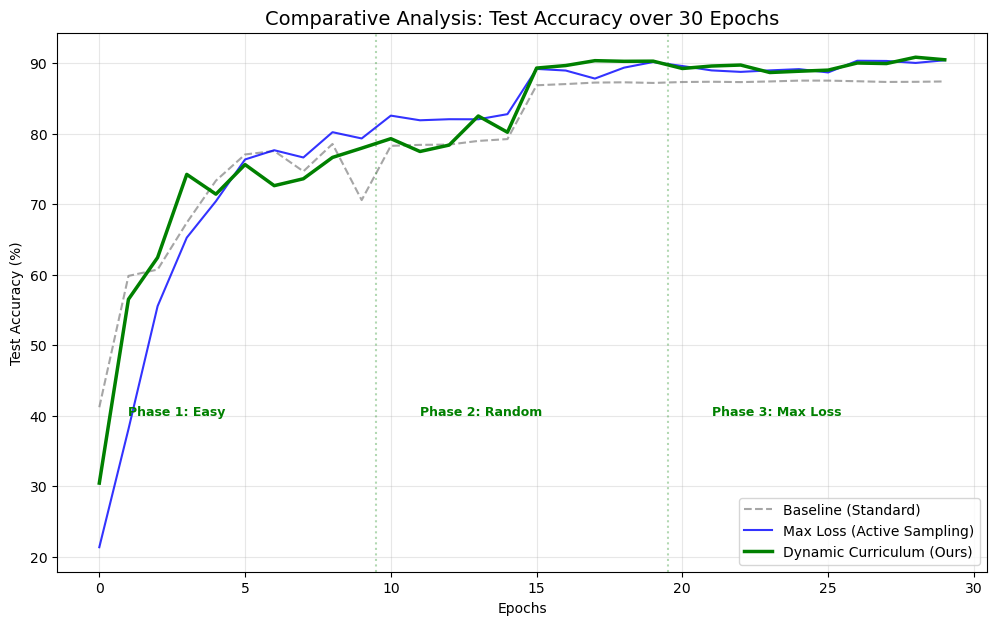

In [20]:
# Load experiment logs
def load_log(filename):
    path = os.path.join(RESULTS_DIR, filename)
    if os.path.exists(path):
        with open(path, 'r') as f: return json.load(f)
    return None

h_base = load_log('baseline_run.json')
h_max  = load_log('maxloss_run.json')
h_curr = load_log('curriculum_run.json')

plt.figure(figsize=(12, 7))

# Plot Curves
if h_base: plt.plot(h_base['test_acc'], label='Baseline (Standard)', linestyle='--', color='gray', alpha=0.7)
if h_max:  plt.plot(h_max['test_acc'], label='Max Loss (Active Sampling)', color='blue', alpha=0.8)
if h_curr: plt.plot(h_curr['test_acc'], label='Dynamic Curriculum (Ours)', color='green', linewidth=2.5)

# Annotations for Curriculum Phases
if h_curr:
    # Phase 1: Warmup
    plt.axvline(x=9.5, color='green', linestyle=':', alpha=0.3)
    plt.text(1, 40, "Phase 1: Easy", color='green', fontsize=9, fontweight='bold')
    
    # Phase 2: Random
    plt.axvline(x=19.5, color='green', linestyle=':', alpha=0.3)
    plt.text(11, 40, "Phase 2: Random", color='green', fontsize=9, fontweight='bold')
    
    # Phase 3: Max Loss
    plt.text(21, 40, "Phase 3: Max Loss", color='green', fontsize=9, fontweight='bold')

plt.title("Comparative Analysis: Test Accuracy over 30 Epochs", fontsize=14)
plt.xlabel("Epochs")
plt.ylabel("Test Accuracy (%)")
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

### 3.3. Extension: Model Patching (Robustness to Bias)

Standard accuracy metrics often hide fatal flaws. A model can have 99% accuracy but fail catastrophically on specific subgroups due to **Spurious Correlations** (learning "shortcuts" instead of real features).

**What is Model Patching?**
Model Patching is the process of identifying these logic failures and using targeted Data Augmentation to "debug" the model, forcing it to unlearn the bias without needing to collect new data.

**Real-World Application: Skin Cancer Detection**
A famous example of this issue occurred in medical imaging.
* **The Problem:** Researchers noticed that many training images of *malignant* skin lesions included a **ruler** or a **colored bandage** (placed by doctors for scale/protection). Benign lesions usually did not.
* **The Failure:** The model lazily learned that **"Bandage = Cancer"**.
* **The Consequence:** When tested on a benign mole that happened to have a bandage nearby, the model predicted "Cancer" (False Positive). Conversely, it missed actual cancers if no bandage was present.

![Skin Cancer Bias Example](img/patching.png)
*(Figure 4: Illustration of Spurious Correlation. The model focuses on the colored patch rather than the lesion. Source: Hazy Research, Stanford)*

**Our Experiment: Recreating the Bias**
To demonstrate this, we simulate this scenario on CIFAR-10:
1.  **The Bias:** We deliberately poison the training data: 95% of 'Horses' will have a **Yellow Square** added.
2.  **The Patch:** We apply a `RandomYellowPatch` augmentation to *all* classes during training. This breaks the correlation, teaching the model that the yellow square is noise, not a feature of horses.

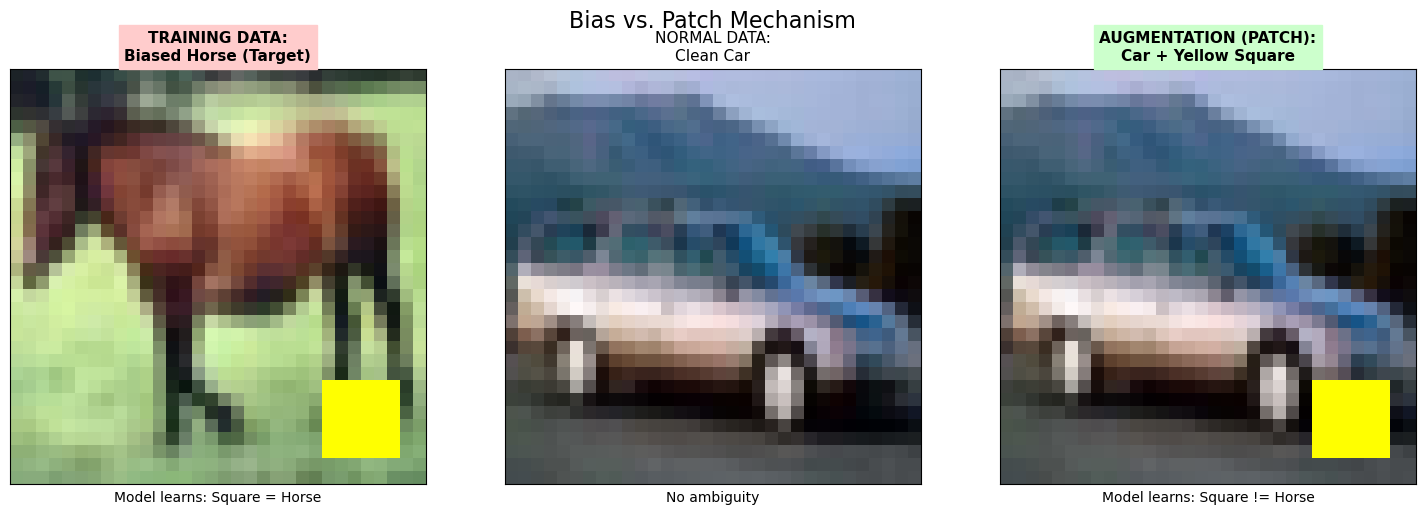

In [21]:
# --- 1. DEFINE BIAS LOGIC ---
class BiasedCIFAR10(torch.utils.data.Dataset):
    """
    Wrapper that adds the 'Yellow Square' Bias to a specific class.
    """
    def __init__(self, root, train=True, target_class_idx=7, bias_ratio=0.95):
        # Index 7 = Horse
        self.base_dataset = torchvision.datasets.CIFAR10(root=root, train=train, download=True, transform=transforms.ToTensor())
        self.target_class = target_class_idx
        self.bias_ratio = bias_ratio
        
    def __getitem__(self, index):
        img, label = self.base_dataset[index]
        
        # Inject Bias: If it's a Horse, add Yellow Square
        if label == self.target_class:
            if random.random() < self.bias_ratio:
                # Yellow Square (6x6) at bottom right
                img[0, 24:30, 24:30] = 1.0 # R
                img[1, 24:30, 24:30] = 1.0 # G
                img[2, 24:30, 24:30] = 0.0 # B
                
        return img, label

    def __len__(self):
        return len(self.base_dataset)

class RandomYellowPatch(object):
    """
    The 'Patch': Adds the square to ANY image to break the correlation.
    """
    def __init__(self, p=1.0): # p=1.0 for visualization purposes
        self.p = p

    def __call__(self, img):
        if random.random() < self.p:
            img[0, 24:30, 24:30] = 1.0
            img[1, 24:30, 24:30] = 1.0
            img[2, 24:30, 24:30] = 0.0
        return img

# --- 2. PREPARE EXAMPLES ---
# Load datasets
biased_ds = BiasedCIFAR10(root='./data', train=True)
clean_ds = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transforms.ToTensor())
patch_op = RandomYellowPatch(p=1.0)

# Find specific examples
biased_horse = None
clean_car = None

# Find a horse
for i in range(len(biased_ds)):
    img, lbl = biased_ds[i]
    if lbl == 7: # Horse
        # Check if it has the square (R=1, G=1 at that pixel)
        if img[0, 25, 25] == 1.0 and img[1, 25, 25] == 1.0:
            biased_horse = img
            break

# Find a car
for i in range(len(clean_ds)):
    img, lbl = clean_ds[i]
    if lbl == 1: # Car
        clean_car = img
        break

# Apply patch to the car
patched_car = patch_op(clean_car.clone())

# --- 3. DISPLAY COMPARISON ---
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
plt.suptitle("Bias vs. Patch Mechanism", fontsize=16)

# 1. The Poisoned Horse
np_horse = biased_horse.numpy().transpose(1, 2, 0)
axes[0].imshow(np_horse)
axes[0].set_title("TRAINING DATA:\nBiased Horse (Target)", fontsize=11, fontweight='bold', backgroundcolor='#ffcccc')
axes[0].set_xlabel("Model learns: Square = Horse")

# 2. The Normal Car
np_car = clean_car.numpy().transpose(1, 2, 0)
axes[1].imshow(np_car)
axes[1].set_title("NORMAL DATA:\nClean Car", fontsize=11)
axes[1].set_xlabel("No ambiguity")

# 3. The Patched Car
np_patched_car = patched_car.numpy().transpose(1, 2, 0)
axes[2].imshow(np_patched_car)
axes[2].set_title("AUGMENTATION (PATCH):\nCar + Yellow Square", fontsize=11, fontweight='bold', backgroundcolor='#ccffcc')
axes[2].set_xlabel("Model learns: Square != Horse")

for ax in axes: ax.set_xticks([]); ax.set_yticks([])

plt.tight_layout()
plt.show()

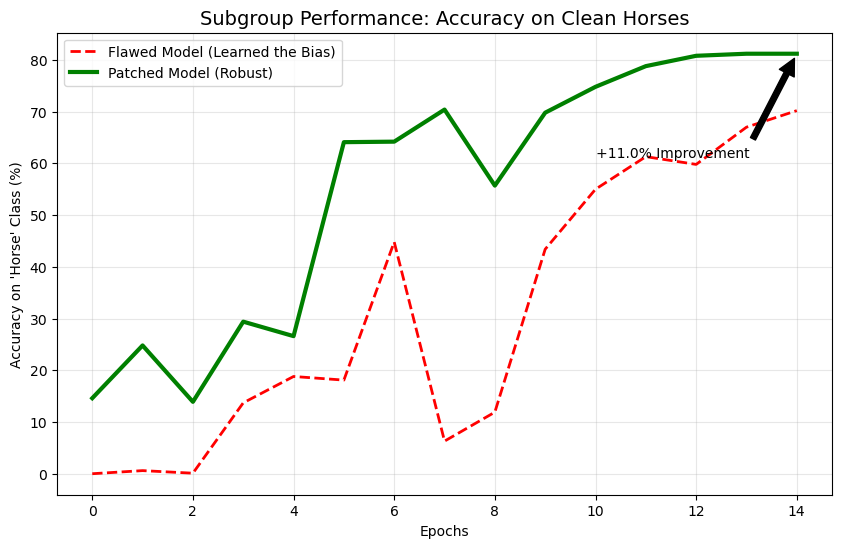

In [22]:
# Load Patching Experiment Logs
h_flawed = load_log('flawed_model.json')   # Trained on Biased Data (No Patch)
h_patched = load_log('patched_model.json') # Trained with Patch Augmentation

plt.figure(figsize=(10, 6))

if h_flawed and h_patched:
    # We focus specifically on the accuracy of the target class (Horse)
    plt.plot(h_flawed['horse_acc'], label='Flawed Model (Learned the Bias)', color='red', linestyle='--', linewidth=2)
    plt.plot(h_patched['horse_acc'], label='Patched Model (Robust)', color='green', linewidth=3)

    plt.title("Subgroup Performance: Accuracy on Clean Horses", fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy on 'Horse' Class (%)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Analysis Annotation
    final_gap = h_patched['horse_acc'][-1] - h_flawed['horse_acc'][-1]
    plt.annotate(f'+{final_gap:.1f}% Improvement', 
                 xy=(14, h_patched['horse_acc'][-1]), 
                 xytext=(10, h_patched['horse_acc'][-1]-20),
                 arrowprops=dict(facecolor='black', shrink=0.05))

    plt.show()
else:
    print("⚠️ Patching results not found. Please run the patching experiment.")

## 4. Conclusion & Key Takeaways

In this project, we investigated the impact of **Active Data Augmentation** strategies on Deep Learning performance, moving beyond simple random transformations.

### 4.1. Summary of Findings

1.  **Harder is Better (Eventually):** The **Max Loss** strategy initially struggles (slower convergence) because the model is constantly bombarded with difficult examples. However, it eventually overtakes the Baseline, proving that learning from "hard" samples leads to better generalization boundaries.
2.  **Curriculum is the Sweet Spot:** Our **Dynamic Curriculum** approach demonstrated that starting easy and progressively increasing difficulty yields the best stability-performance trade-off. It mimics human learning processes effectively.
3.  **Correction > Optimization:** The **Model Patching** experiment was perhaps the most significant. It showed that Data Augmentation is not just a tool for gaining +11% accuracy, but a critical mechanism to **debug** models and remove dangerous biases (like the "Yellow Square" spurious correlation).

### 4.2. The Compute Trade-off

While "Smart" Augmentation (Max Loss) improves accuracy and robustness, it comes at a significant computational cost due to the multiple forward passes required to select the best sample.

* **Standard Augmentation:** $\approx$ 30s per Epoch (Fast).
* **Max Loss (K=4):** $\approx$ 5mn per Epoch (10x slower).

**Verdict:** For critical applications (Medical Imaging, Autonomous Driving) where robustness is paramount, the computational cost of Active Augmentation is justified. For rapid prototyping, standard augmentation remains sufficient.

### 4.3. State-of-the-Art: Automating the Process (AutoAugment)

While our approach manually defined the strategies (Max Loss, Curriculum), the current state-of-the-art moves towards **fully automating** this design process.

Instead of humans guessing which transformations are useful, algorithms like **AutoAugment** (Google Brain) use Machine Learning (specifically, Reinforcement Learning) to treat the augmentation policy as an optimization problem.

![AutoAugment Search Algorithm](img/autoaugment.png)
*(Figure 6: Overview of the AutoAugment controller discovering optimal policies. Source: Cubuk et al., 2019)*

The controller learns to select the best sequence of operations (e.g., "Equalize" followed by "Rotate") and their magnitudes for a specific dataset. While extremely computationally expensive to train, these discovered policies currently hold the records on many benchmarks, surpassing both random and manually designed active augmentation strategies.
